In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

shape_bias_dir = "/home/ainedineen/blurry_vision/pytorch_untrained_models/imagenet/exp1_blurry_vision/exp1_model_shape_bias_train_and_test_blur/shape_bias"

_train_test_files = glob.glob(os.path.join(shape_bias_dir, "shape_bias_train-*_test-*_16_class_IN.csv"))


shape_bias_df = pd.DataFrame()
# Load all csvs in directpry /shape_bias_train-*_test-0*_16_class_IN.csv
for file in _train_test_files:
    print(file)
    df = pd.read_csv(file)
    print(df.head())
    # Get the name of the file without the extension
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Save the dataframe to a new csv file in the new directory
    # df.to_csv(os.path.join(file_name, "data.csv"), index=False)

    # extract total shape bias, get value from 'Shape_Bias' column from row with category == 'Total'
    
    # Category  Shape_Choices  Texture_Choices  Other_Choices  Shape_Bias
    total_shape_bias = df.loc[df['Category'] == 'Total', 'Shape_Bias'].values[0]
    print(f"Total shape bias: {total_shape_bias}")
    # extract train_blur and test_blur from the file name shape_bias_train-2_test-0_16_class_IN.csv
    train_blur = float(file.split('/')[-1].split('train-')[1].split('_')[0])
    test_blur = float(file.split('/')[-1].split('test-')[1].split('_')[0])
    print(f"Train blur: {train_blur}, Test blur: {test_blur}")



    n_shape_choices = df.loc[df['Category'] == 'Total', 'Shape_Choices'].values[0]
    n_texture_choices = df.loc[df['Category'] == 'Total', 'Texture_Choices'].values[0]
    n_other_choices = df.loc[df['Category'] == 'Total', 'Other_Choices'].values[0]
    proportion_correct = ((n_shape_choices + n_texture_choices) / (n_other_choices + n_shape_choices + n_texture_choices))  * 100

    total_texture_bias = (n_texture_choices / (n_texture_choices + n_shape_choices)) * 100


    # add train_blur, test_blur and total_shape_bias to the dataframe
    shape_bias_df = shape_bias_df.append({
        'train_blur': train_blur,
        'test_blur': test_blur,
        'total_shape_bias': total_shape_bias,
        'total_texture_bias': total_texture_bias,
        'n_shape_choices': n_shape_choices,
        'n_texture_choices': n_texture_choices,
        # 'n_other_choices': n_§other_choices,
        'proportion_correct': proportion_correct
    }, ignore_index=True)

    # int(file.split('_')[1].split('-')[1])



# Using glob Load all csvs in directpry /shape_bias_train-*_test-0*_16_class_IN.csv

/home/ainedineen/blurry_vision/pytorch_untrained_models/imagenet/exp1_blurry_vision/exp1_model_shape_bias_train_and_test_blur/shape_bias/shape_bias_train-0.5_test-1_16_class_IN.csv
   Category  Shape_Choices  Texture_Choices  Other_Choices  Shape_Bias
0     Total            268              428            504    0.385057
1  airplane              3               33             39    0.083333
2   bicycle             30               24             21    0.555556
3      boat              7               28             40    0.200000
4       car             24               25             26    0.489796
Total shape bias: 0.3850574712643678
Train blur: 0.5, Test blur: 1.0
/home/ainedineen/blurry_vision/pytorch_untrained_models/imagenet/exp1_blurry_vision/exp1_model_shape_bias_train_and_test_blur/shape_bias/shape_bias_train-2_test-6_16_class_IN.csv
   Category  Shape_Choices  Texture_Choices  Other_Choices  Shape_Bias
0     Total            222               91            887    0.709265
1  

In [40]:
shape_bias_df

,n_shape_choices,n_texture_choices,proportion_correct,test_blur,total_shape_bias,total_texture_bias,train_blur
0,268.0,428.0,58.000000,1.0,0.385057,61.494253,0.5
1,222.0,91.0,26.083333,6.0,0.709265,29.073482,2.0
2,218.0,110.0,27.333333,4.0,0.664634,33.536585,0.0
3,307.0,281.0,49.000000,2.0,0.522109,47.789116,1.0
4,185.0,482.0,55.583333,1.0,0.277361,72.263868,1.0
...,...,...,...,...,...,...,...
59,293.0,100.0,32.750000,4.0,0.745547,25.445293,1.0
60,318.0,272.0,49.166667,1.5,0.538983,46.101695,0.5
61,146.0,223.0,30.750000,3.0,0.395664,60.433604,4.0
62,107.0,168.0,22.916667,1.5,0.389091,61.090909,3.0


In [ ]:

def plot_shape_bias_heatmap(shape_bias_df, metric_to_plot, metric_label, plot_label, save_path, mask=False):

    df = shape_bias_df.copy()

    # Pivot the data for heatmap
    heatmap_data = df.pivot_table(
        index='test_blur', 
        columns='train_blur', 
        # values='total_shape_bias', 
        # values='proportion_correct', 
        values=metric_to_plot,
        aggfunc='mean',  # In case there are multiple entries for same (test, train)
    )
    # mask = np.tril(np.ones_like(heatmap_data, dtype=bool))

    # Sort axes if needed
    heatmap_data = heatmap_data.sort_index(ascending=False)  # flip y-axis
    heatmap_data = heatmap_data.sort_index(axis=1)           # sort x-axis


    # Create the heatmap
    plt.figure(figsize=(8, 7))

    if mask:

        # Mask Here - mask lower triangle (diagonal runs from bottom left to top right)
        mask = np.tril(np.ones_like(heatmap_data, dtype=bool), k=-1)
        # fli[p the mask to show upper triangle
        mask = np.flip(mask, axis=1)

        
        sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f",
                    cbar_kws={'label': metric_label},
                    mask=mask
                    )
    else:
        sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f",
                    cbar_kws={'label': metric_label}
                    )
                
    # plt.title('Shape Bias Heatmap')
    # plt.title('Proportion of Correct Labels for Cue Conflict Stimuli')
    plt.title(plot_label)
    plt.xlabel('Train Blur')
    plt.ylabel('Test Blur')
    plt.tight_layout()
    # plt.show()
    # plt.savefig('shape_bias_by_train_and_test_blur.png', dpi=300)
    plt.savefig(save_path, dpi=300)

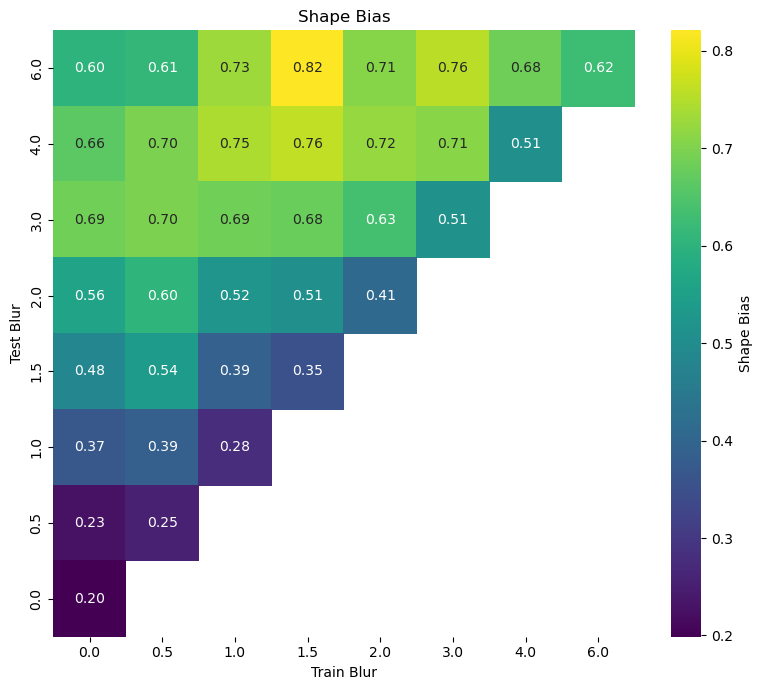

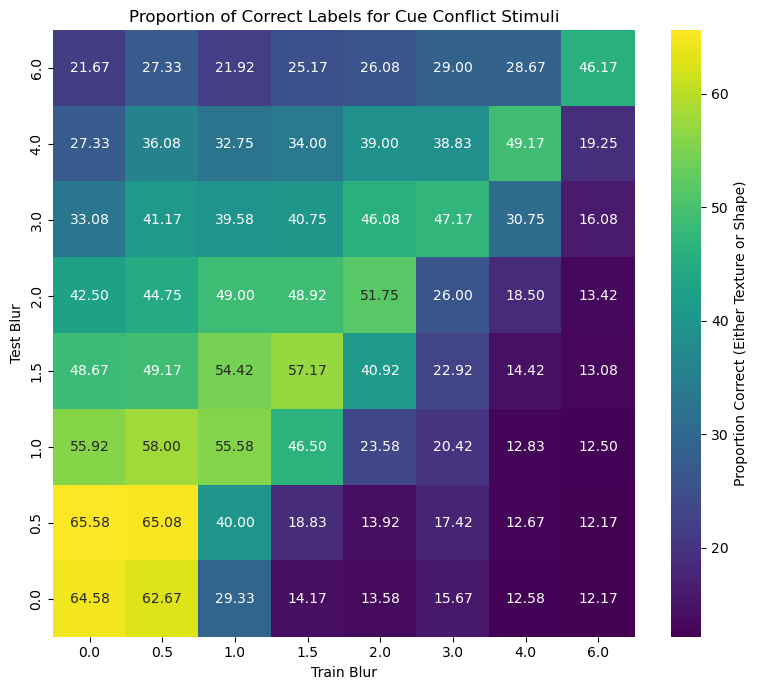

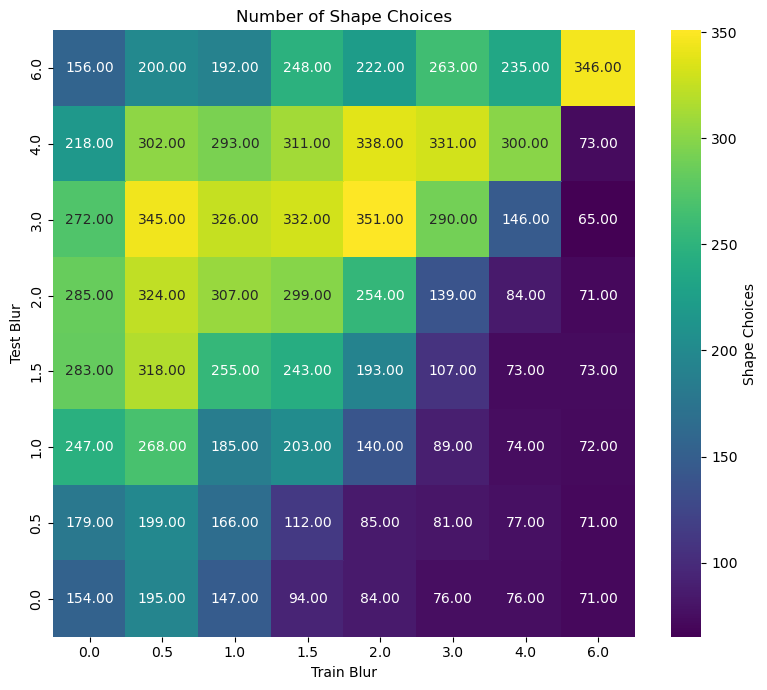

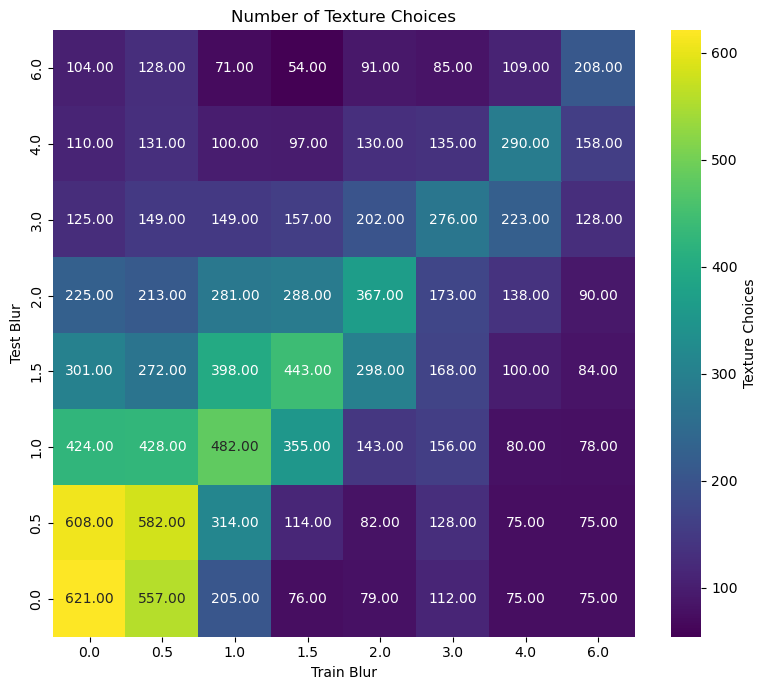

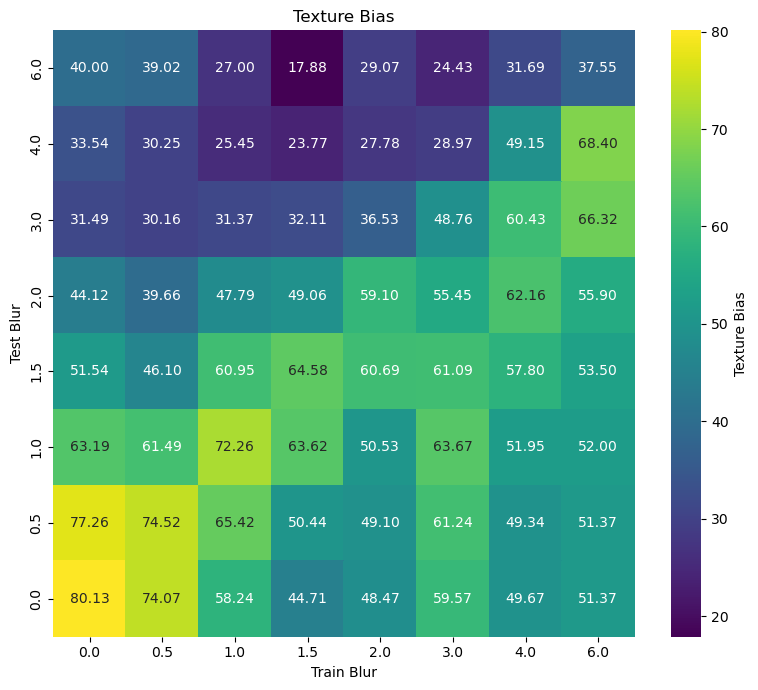

In [37]:
plot_shape_bias_heatmap(shape_bias_df, 'total_shape_bias', 'Shape Bias', 'Shape Bias', 'shape_bias_heatmap.png', mask=True)
plot_shape_bias_heatmap(shape_bias_df, 'proportion_correct', 'Proportion Correct (Either Texture or Shape)', 'Proportion of Correct Labels for Cue Conflict Stimuli', 'proportion_correct_heatmap.png')

plot_shape_bias_heatmap(shape_bias_df, 'n_shape_choices', 'Shape Choices', 'Number of Shape Choices', 'shape_choices_heatmap.png')
plot_shape_bias_heatmap(shape_bias_df, 'n_texture_choices', 'Texture Choices', 'Number of Texture Choices', 'texture_choices_heatmap.png')
plot_shape_bias_heatmap(shape_bias_df, 'total_texture_bias', 'Texture Bias', 'Texture Bias', 'texture_bias_heatmap.png')